<a href="https://colab.research.google.com/github/vidzshan/vidzshan/blob/main/bracemodule.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounting Google Drive

In [2]:
import os
from google.colab import drive

MOUNTPOINT = '/content/gdrive'
DATADIR = os.path.join(MOUNTPOINT, 'My Drive', 'Colab Notebooks','Research')
drive.mount(MOUNTPOINT)

#Access the data
#path = os.path.join(DATADIR, 'data')

#save trained data results or modules
#model.save(os.path.join(DATADIR, 'model.h5'))

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Here is the `requirements.txt` file with the packages you specified. You can use this file to install the dependencies for your project.

In [9]:
%%writefile requirements.txt
smplx
pyrender
trimesh
torch-geometric
essentia

Overwriting requirements.txt


In [ ]:
#pip install -r requirements.txt

In [4]:
import numpy as np
import os
import torch
import smplx

model_path = os.path.join(DATADIR, 'smplx_models','SMPLX_NEUTRAL_2020.npz')

# Load BRACE keypoint sample
keypoints_path = os.path.join(DATADIR, 'brace','manual_keypoints', '2011', '3rIk56dcBTM', 'img-001293.npz')
keypoints_data = np.load(keypoints_path)
keypoints = keypoints_data['coco_joints2d'][:, :2]  # Shape: [17, 2] for x, y coords

# Install SMPL-X dependencies
#!pip install smplx pyrender trimesh
#!git clone https://github.com/vchoutas/smplx /content/smplx
smpl_model = smplx.create(model_path=model_path, model_type='smplx', gender='neutral', use_pca=False, num_betas = 10, num_expression_coeffs=10).to('cuda')
print("SMPL-X loaded successfully!")
# Forward pass with correct tensor shapes
output = smpl_model(
    betas=torch.zeros(1, 10).to('cuda'),
    expression=torch.zeros(1, 10).to('cuda'),
    body_pose=torch.zeros(1, 21*3).to('cuda'),  # 21 joints, 3D rotation each (not 21*6)
    global_orient=torch.zeros(1, 3).to('cuda')   # Add global_orient [1, 3]
)
print(f"Output vertices shape: {output.vertices.shape}")  # Should be [1, 10475, 3]

SMPL-X loaded successfully!
Output vertices shape: torch.Size([1, 10475, 3])


In [5]:
#this cell is responsible for loading, preprocessing, and structuring
#the keypoint and audio data into a format suitable for training a
#Graph Convolutional Network (GCN) model to classify dance types.
import pandas as pd
import torch
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv
import numpy as np
from pathlib import Path
import json

# Load segments.csv
segments = pd.read_csv(Path(DATADIR) / 'brace' / 'annotations' / 'segments.csv')
sequences = segments.head(30)  # 30 sequences

# Define COCO skeleton edges (17 joints)
edge_index = torch.tensor([
    [0,1], [1,2], [2,3], [3,4], [1,5], [5,6], [6,7],  # Head to arms
    [1,8], [8,9], [9,10], [10,11], [8,12], [12,13], [13,14],  # Torso to legs
    [0,15], [0,16]  # Nose to eyes
], dtype=torch.long).t().contiguous()

# Prepare data
data_list = []
for _, row in sequences.iterrows():
    keypoints_file = Path(DATADIR) / 'brace' / 'dataset' / str(row['year']) / row['video_id'] / f"{row['video_id']}_{row['start_frame']}-{row['end_frame']}_{row['dance_type']}.json.json"
    with open(keypoints_file, 'r') as f:
        keypoints_dict = json.load(f)
    keypoints_array = np.array([v['keypoints'] for v in keypoints_dict.values()])[:, :, :2]  # [frames, 17, 2]
    box = list(keypoints_dict.values())[0]['box']  # [x, y, w, h, score]
    keypoints_norm = (keypoints_array - [box[0], box[1]]) / [box[2], box[3]]  # Normalize

    # Compute velocity
    velocity = np.diff(keypoints_norm, axis=0, prepend=keypoints_norm[:1])  # [frames, 17, 2]

    # Load audio features
    audio_file = Path(DATADIR) / 'brace' / 'audio_features' / str(row['year']) / row['video_id'] / f"{row['video_id']}.{row['seq_idx']}.npz"
    if audio_file.exists():
        audio_data = np.load(audio_file)
        onset_beat = audio_data['onset_beat'].flatten()  # Ensure 1D array
        if len(onset_beat) > 1:  # Ensure enough points for interpolation
            onset_beat = np.interp(
                np.arange(len(keypoints_norm)),
                np.linspace(0, len(onset_beat)-1, len(onset_beat)),
                onset_beat
            )  # Align to keypoint frames
            onset_beat = onset_beat[:, np.newaxis, np.newaxis]  # [frames, 1, 1]
            x = np.concatenate([keypoints_norm.reshape(-1, 17*2), velocity.reshape(-1, 17*2), onset_beat.reshape(-1, 1)], axis=1)  # [frames, 69]
        else:
            x = np.concatenate([keypoints_norm.reshape(-1, 17*2), velocity.reshape(-1, 17*2)], axis=1)  # [frames, 68]
    else:
        x = np.concatenate([keypoints_norm.reshape(-1, 17*2), velocity.reshape(-1, 17*2)], axis=1)  # [frames, 68]

    x = torch.tensor(x, dtype=torch.float)
    y = torch.tensor(row['dance_type_id'], dtype=torch.long)
    data = Data(x=x, edge_index=edge_index, y=y)
    data_list.append(data)

In [6]:
#standard training loop for a PyTorch model, including forward and backward
#passes, optimizer steps, and periodic evaluation on a validation set.

# GCN model
class GCN(torch.nn.Module): #The base class for all neural network model
    def __init__(self):
        super(GCN, self).__init__()
        #First graph convolutional layer
        self.conv1 = GCNConv(69, 64)  # 34 (keypoints) + 34 (velocity) + 1 (onset_beat)
        #Second graph convolutional layer
        self.conv2 = GCNConv(64, 3)   # 3 classes

    def forward(self, data):#data flows through the network
        x, edge_index, batch = data.x, data.edge_index, data.batch  # Add batch for batched graphs
        x = torch.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        # Pool per graph in batch using global_mean_pool
        from torch_geometric.nn import global_mean_pool
        x = global_mean_pool(x, batch)  # Shape: [batch_size, 3]
        return x

# Train
model = GCN().to('cuda')
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)#Adam optimizer,
#lr: learning rate
criterion = torch.nn.CrossEntropyLoss()#Loss function
loader = DataLoader(data_list[:24], batch_size=4, shuffle=True)  # 80% train
val_loader = DataLoader(data_list[24:], batch_size=4)  # 20% val, validation data

#set the model to training mode
model.train()
for epoch in range(5):
    for data in loader:
        data = data.to('cuda')
        optimizer.zero_grad()
        out = model(data)  # Shape: [batch_size, 3] (e.g., [4, 3])
        loss = criterion(out, data.y)  # data.y is [batch_size] (e.g., [4])
        loss.backward()
        #every time your training loop runs a batch,
        #backpropagation occurs through loss.backward().
        #No manual gradient code is needed; PyTorch
        #auto-differentiation handles it all for you!
        optimizer.step()
    # Validate
    model.eval()
    correct = 0
    total = 0
    for data in val_loader:
        data = data.to('cuda')
        out = model(data)
        pred = out.argmax(dim=1)  # Predict per batch
        correct += (pred == data.y).sum().item()
        total += len(data.y)
    print(f"Epoch {epoch+1}, Val Accuracy: {correct/total:.2f}")

/usr/local/lib/python3.12/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 1, Val Accuracy: 0.50
Epoch 2, Val Accuracy: 0.33
Epoch 3, Val Accuracy: 0.50
Epoch 4, Val Accuracy: 0.50
Epoch 5, Val Accuracy: 0.33


In [8]:
print(sum(p.numel() for p in model.parameters()))


4675


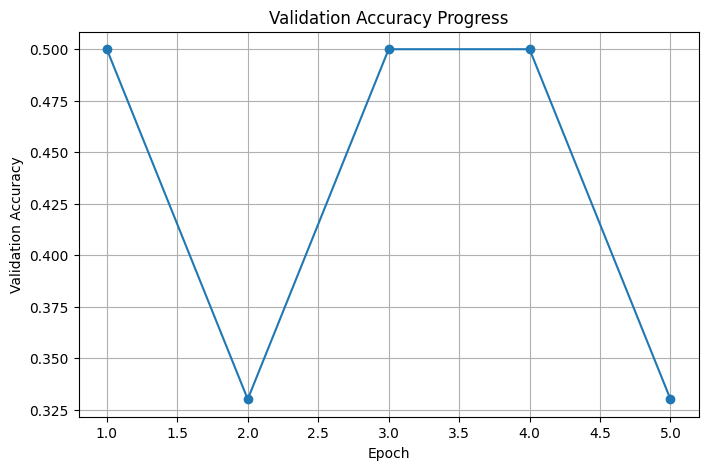

In [10]:
#Validation accuracy progress
#How my model's accuracy changes as training progresses
#Trend of improvements, stagnation, fluctuation
import matplotlib.pyplot as plt

epochs = [1, 2, 3, 4, 5]
val_accuracy = [0.50, 0.33, 0.50, 0.50, 0.33]

plt.figure(figsize=(8,5))
plt.plot(epochs, val_accuracy, marker='o', linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy Progress')
plt.grid(True)
plt.show()
